# plotting loss

In [149]:
import os

losses_path = "losses"
print("Losses path: {}".format(losses_path))
print("Loss files available: {}".format("\n".join(os.listdir(losses_path))))

loss_path = "gaussian_true_normalized_exp_norelu.1205_v1.txt"
with open(os.path.join(losses_path, loss_path)) as f:
    raw_data = f.readlines()

Losses path: losses
Loss files available: gaussian_true_normalized_exp_norelu.1204.txt
gaussian_true_normalized_exp_norelu.1205_v1.txt
gaussian_true_normalized_exp_norelu_v3.txt


In [150]:
from collections import defaultdict
import re

data = defaultdict(dict)

psnr_idxs = []
iteration = 0
for line in raw_data:
    if "PSNR" in line:
        iteration = int(line.split("/")[0])
        loss = line.split("loss = ")[1].split(",")[0]
        psnr = line.split("PSNR = ")[1].split(" ")[0]
        data[(iteration)] = {"loss": float(loss), "psnr": float(psnr)}
        psnr_idxs.append((iteration))
    elif "top_loss" in line:
        data[iteration]["top_loss"] = float(line.split(" ")[-1])
    elif "bottom_loss" in line:
        data[iteration]["bottom_loss"] = float(line.split(" ")[-1])
    elif "coef_loss" in line:
        data[iteration]["coef_loss"] = float(line.split(" ")[-1])
        iteration += 1

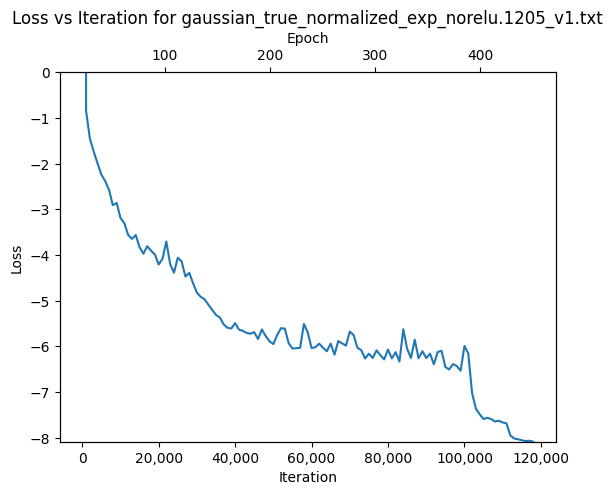

In [151]:
# plot iteration vs loss of the data
from matplotlib import pyplot as plt
import numpy as np

num_training_imgs = 8000
iterations2epoch = num_training_imgs / 32  # 4 is the batch size
losses = np.array([data[i]["loss"] for i in psnr_idxs])
plt.plot(psnr_idxs, losses)
# label axes
plt.xlabel("Iteration")
plt.ylabel("Loss")
# set y axes as logarithmic
# plt.yscale("log")
# set title
plt.title("Loss vs Iteration for {}".format(loss_path))
# put commas in the x axis
plt.gca().get_xaxis().set_major_formatter(
    plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x)))
)
# set another x axis
ax2 = plt.twiny()
# set the x axis to be the first one divided by 8000 but with the same ticks
ax2.set_xticks(
    [
        psnr_idx / iterations2epoch
        for psnr_idx in psnr_idxs
        if psnr_idx % iterations2epoch == 0 and (psnr_idx // iterations2epoch) % 50 == 0
    ]
)
ax2.set_xlim(0, (psnr_idxs[-1] / iterations2epoch))
ax2.set_ylim(np.min(losses), 0)
# set the x axis label
ax2.set_xlabel("Epoch")
plt.show()

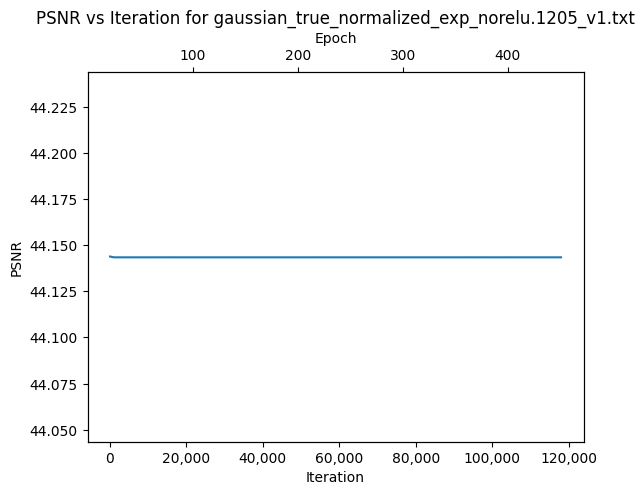

In [152]:
num_training_imgs = 8000
iterations2epoch = num_training_imgs / 32  # 4 is the batch size
psnrsss = np.array([data[i]["psnr"] for i in psnr_idxs])
plt.plot(psnr_idxs, psnrsss)
# label axes
plt.xlabel("Iteration")
plt.ylabel("PSNR")
# set y axes as logarithmic
# plt.yscale("log")
# set title
plt.title("PSNR vs Iteration for {}".format(loss_path))
# put commas in the x axis
plt.gca().get_xaxis().set_major_formatter(
    plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x)))
)
# set another x axis
ax2 = plt.twiny()
# set the x axis to be the first one divided by 8000 but with the same ticks
ax2.set_xticks(
    [
        psnr_idx / iterations2epoch
        for psnr_idx in psnr_idxs
        if psnr_idx % iterations2epoch == 0 and (psnr_idx // iterations2epoch) % 50 == 0
    ]
)
ax2.set_xlim(0, (psnr_idxs[-1] / iterations2epoch))
ax2.set_ylim(np.min(psnrsss) - 0.1, np.max(psnrsss) + 0.1)


# set the x axis label
ax2.set_xlabel("Epoch")
plt.show()

0


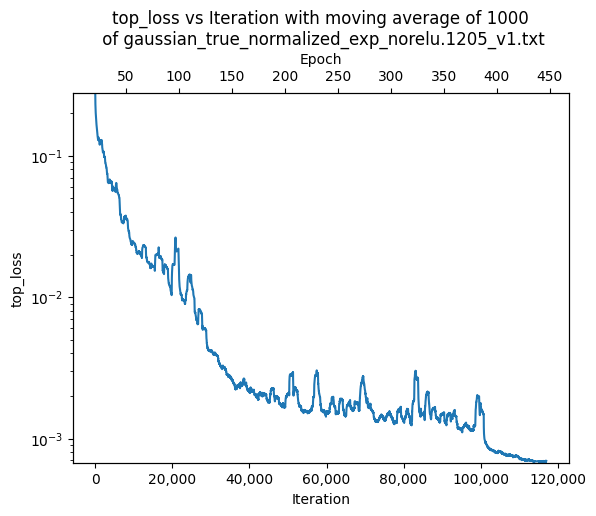

0


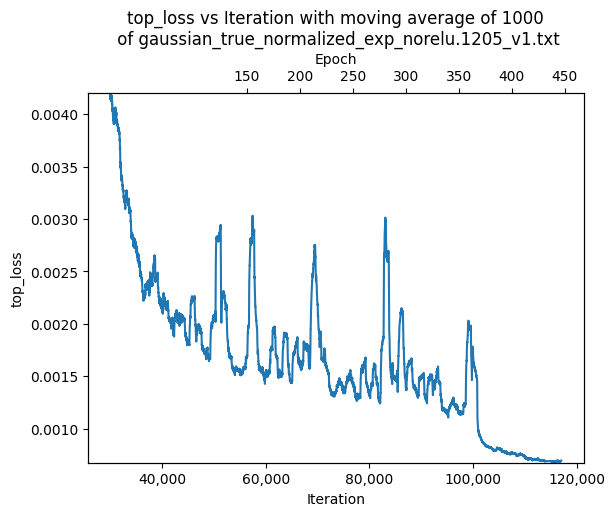

0


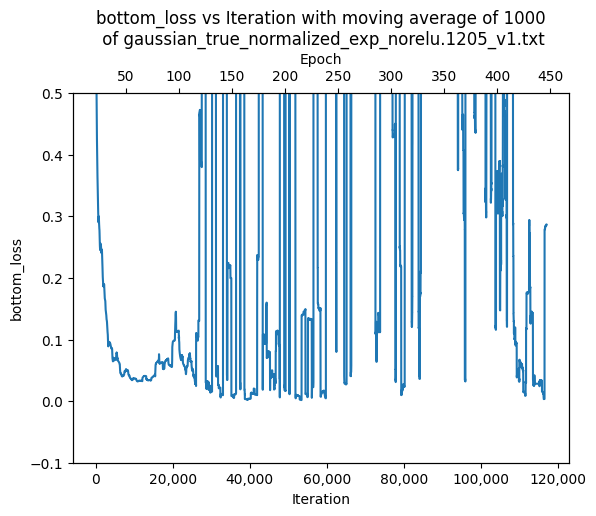

0


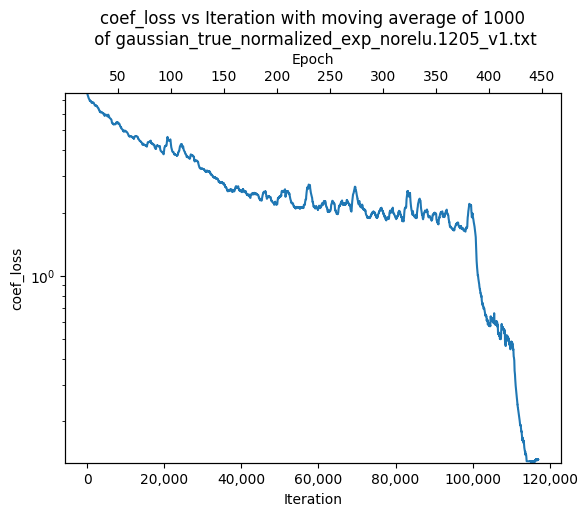

66999


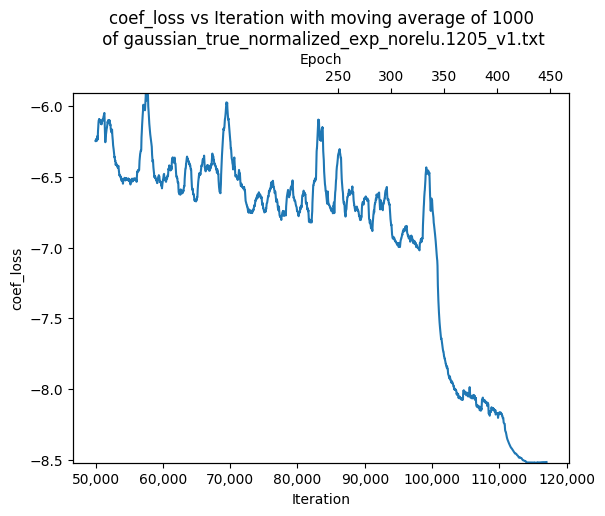

In [153]:
subject = "top_loss"


def show_loss_parts(subject, start_iter, data=data, psnr_idxs=psnr_idxs, ylims=None, log=False):
    num_training_imgs = 8000
    iterations2epoch = num_training_imgs / 32  # 4 is the batch size
    psnrsss = np.array([data[i]["psnr"] for i in psnr_idxs])
    iters = [i for i in data.keys() if subject in data[i] and i > start_iter]
    extracted_data = [data[i][subject] for i in iters]
    if log:
        smallest = np.min(extracted_data) 
        if smallest < 0:
            extracted_data = [data[i][subject] + abs(smallest) + 1e-10 for i in iters]
    n_moving_average = 1000
    extracted_moving_average = [
        np.mean(extracted_data[i : i + n_moving_average])
        for i in range(len(extracted_data) - n_moving_average)
    ]
    iters = iters[:-n_moving_average]
    
    print(sum([x < 0 for x in extracted_moving_average]))

    plt.plot(iters, extracted_moving_average)
    # label axes
    plt.xlabel("Iteration")
    plt.ylabel(f"{subject}")
    # set y axes as logarithmic
    if log:
        plt.yscale("log")
        

    # set title
    plt.title(
        f"{subject} vs Iteration with moving average of {n_moving_average}\n of {loss_path}"
    )
    # put commas in the x axis
    plt.gca().get_xaxis().set_major_formatter(
        plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x)))
    )
    # set another x axis
    ax2 = plt.twiny()
    # set the x axis to be the first one divided by 8000 but with the same ticks
    ax2.set_xticks(
        [
            psnr_idx / iterations2epoch
            for psnr_idx in iters
            if psnr_idx % iterations2epoch == 0
            and (psnr_idx // iterations2epoch) % 50 == 0
        ]
    )
    ax2.set_xlim(0, (list(iters)[-1] / iterations2epoch))
    if ylims:
        ax2.set_ylim(ylims[0], ylims[1])
    else:
        ax2.set_ylim(np.min(extracted_moving_average), np.max(extracted_moving_average))
    # set the x axis label
    ax2.set_xlabel("Epoch")
    plt.show()


show_loss_parts("top_loss", start_iter=0000, log=True)
show_loss_parts("top_loss", start_iter=30000)
show_loss_parts("bottom_loss", start_iter=0000, ylims=[-0.1, 0.5])
show_loss_parts("coef_loss", start_iter=0000, log=True)
show_loss_parts("coef_loss", start_iter=50000)

# Random test shit


In [36]:
import numpy as np

data = np.zeros((512, 512, 1))
np.squeeze(data).shape

(512, 512)

In [37]:
np.stack(
    (np.squeeze(data), np.squeeze(data), np.squeeze(data), np.squeeze(data)), axis=-1
).shape

(512, 512, 4)